### El Nino and La Nina distributions of TXx
1. Read in TXx data
2. Read in obs SST data (for the length of HadEX) and compute Nino3.4 index
3. Define El Nino and La Nina events
4. Plot PDF of TXx for El Nino years and PDF of TXx for La Nina years
5. Test if the two distributions are significantly different 

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
from importlib import reload
from scipy import stats 
import cartopy.crs as ccrs

In [3]:
#Read in TXx from HadEX3
hadex_TXx_ds = xr.open_dataset('HadEX3_TXx_1901-2018_ADW_61-90_1.25x1.875deg.nc')
TXx_ann = hadex_TXx_ds.Ann

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'Ann' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'Jan' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'Feb' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'Mar' has multiple fill values {-99.9, -99.9}, decoding all values to NaN.
  new_vars[k] = deco

In [4]:
#open ersst datset
ersst_ds = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.nc')
#select out sst data for period of HadEX (1901-2018)
ersst_sst = ersst_ds.sst.sel(time=slice('1901-01', '2018-12'))
#detrend
ersst_detrend = np.apply_along_axis(func.detrend_2step, 0, ersst_sst)
ersst_sst_dt = xr.DataArray(ersst_detrend, coords=ersst_sst.coords, attrs=ersst_sst.attrs)

In [5]:
#calculate nino34 index 
nino34_index =  func.nino34_index(ersst_sst_dt, '1950-01', '1979-12') #what climatology to use?
#use index to find el nino and la nina event years 
el_nino_years, la_nina_years = func.find_event_years(nino34_index, 0.4, 6)

### Annual

In [6]:
#Select out TXx data for el nino years
TXx_el_nino = TXx_ann.sel(time=el_nino_years)
#Select out TXx data for la nina years
TXx_la_nina = TXx_ann.sel(time=la_nina_years)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TXx [Degrees C]', ylabel='Density'>

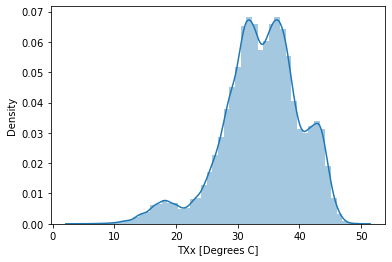

In [7]:
#Plot TXx distribution for El Nino years
sns.distplot(TXx_el_nino, axlabel='TXx [Degrees C]')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TXx [Degrees C]', ylabel='Density'>

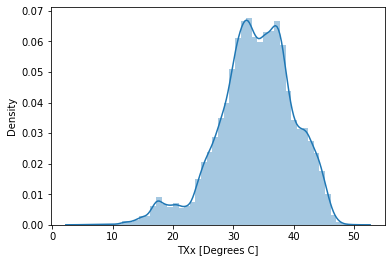

In [8]:
#Plot TXx distribution for La Nina years
sns.distplot(TXx_la_nina, axlabel='TXx [Degrees C]')

In [9]:
t, p = stats.ttest_ind(TXx_el_nino, TXx_la_nina, nan_policy='omit')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/scipy/stats/mstats_basic.py:1071: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!


In [10]:
lats = TXx_el_nino.latitude
lons = TXx_el_nino.longitude

In [13]:
diff = TXx_el_nino.mean(dim='time') - TXx_la_nina.mean(dim='time')

In [16]:
#mask out p values >0.05
p_sig = np.ma.masked_where(p>0.05, p)

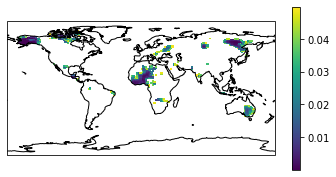

In [17]:
ax=plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(lons, lats, p_sig, transform=ccrs.PlateCarree())
ax.coastlines()
plt.colorbar(shrink=0.75)
plt.show()

Text(0, 0.5, 'Degrees C')

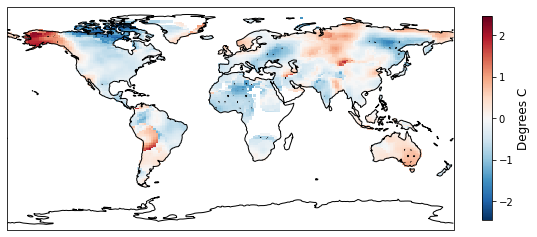

In [36]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
C = diff.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree())
plt.contourf(lons, lats, p_sig, hatches=[None,'..'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
cbar = plt.colorbar(C, ax=ax, shrink=0.75, pad=0.05)
cbar.ax.set_ylabel('Degrees C', fontsize=12)

### Seasonal

In [20]:
#select out monthly data 
TXx_jan = hadex_TXx_ds.Jan.drop_sel(time=1901) #drop first year 
TXx_feb = hadex_TXx_ds.Feb.drop_sel(time=1901)
TXx_mar = hadex_TXx_ds.Mar.drop_sel(time=1901)
TXx_apr = hadex_TXx_ds.Apr.drop_sel(time=1901)
TXx_may = hadex_TXx_ds.May.drop_sel(time=1901)
TXx_jun = hadex_TXx_ds.Jun.drop_sel(time=1901)
TXx_jul = hadex_TXx_ds.Jul.drop_sel(time=1901)
TXx_aug = hadex_TXx_ds.Aug.drop_sel(time=1901)
TXx_sep = hadex_TXx_ds.Sep.drop_sel(time=1901)
TXx_oct = hadex_TXx_ds.Oct.drop_sel(time=1901)
TXx_nov = hadex_TXx_ds.Nov.drop_sel(time=1901)
TXx_dec = hadex_TXx_ds.Dec #keep previous year december 

In [21]:
#make december years match jan and feb for before taking seasonal averages
TXx_dec_shifted = func.change_dec_years(TXx_dec)

In [22]:
#find seasonal maximum of TXx 
max_TXx_dec_jan = np.maximum(TXx_dec, TXx_jan)
seasonal_TXx_djf = np.maximum(max_TXx_dec_jan, TXx_feb)
max_TXx_sep_oct = np.maximum(TXx_sep, TXx_oct)
seasonal_TXx_son = np.maximum(max_TXx_sep_oct, TXx_nov)
max_TXx_jun_jul = np.maximum(TXx_jun, TXx_jul)
seasonal_TXx_jja = np.maximum(max_TXx_jun_jul, TXx_aug)
max_TXx_mar_apr = np.maximum(TXx_mar, TXx_apr)
seasonal_TXx_mam = np.maximum(max_TXx_mar_apr, TXx_may)

In [23]:
#offset el nino and la nina years forward one year for DJF and MAM as we want season following initiation of event
el_nino_years_offset = el_nino_years +1
la_nina_years_offset = la_nina_years +1

In [24]:
#select out all el nino years for each season (use offset for DJF and MAM)
seasonal_TXx_jja_el_nino = seasonal_TXx_jja.sel(time=el_nino_years)
seasonal_TXx_son_el_nino = seasonal_TXx_son.sel(time=el_nino_years)
seasonal_TXx_djf_el_nino = seasonal_TXx_djf.sel(time=el_nino_years_offset)
seasonal_TXx_mam_el_nino = seasonal_TXx_mam.sel(time=el_nino_years_offset)

In [25]:
#select out all la nina years for each season (use offset for DJF and MAM)
seasonal_TXx_jja_la_nina = seasonal_TXx_jja.sel(time=la_nina_years)
seasonal_TXx_son_la_nina = seasonal_TXx_son.sel(time=la_nina_years)
seasonal_TXx_djf_la_nina = seasonal_TXx_djf.sel(time=la_nina_years_offset)
seasonal_TXx_mam_la_nina = seasonal_TXx_mam.sel(time=la_nina_years_offset)

In [30]:
#difference between composites
TXx_comp_diff_jja = seasonal_TXx_jja_el_nino.mean(dim='time') - seasonal_TXx_jja_la_nina.mean(dim='time')
TXx_comp_diff_son = seasonal_TXx_son_el_nino.mean(dim='time') - seasonal_TXx_son_la_nina.mean(dim='time')
TXx_comp_diff_djf = seasonal_TXx_djf_el_nino.mean(dim='time') - seasonal_TXx_djf_la_nina.mean(dim='time')
TXx_comp_diff_mam = seasonal_TXx_mam_el_nino.mean(dim='time') - seasonal_TXx_mam_la_nina.mean(dim='time')

In [29]:
#p values
t_jja, p_jja = stats.ttest_ind(seasonal_TXx_jja_el_nino, seasonal_TXx_jja_la_nina, nan_policy='omit')
t_son, p_son = stats.ttest_ind(seasonal_TXx_son_el_nino, seasonal_TXx_son_la_nina, nan_policy='omit')
t_djf, p_djf = stats.ttest_ind(seasonal_TXx_djf_el_nino, seasonal_TXx_djf_la_nina, nan_policy='omit')
t_mam, p_mam = stats.ttest_ind(seasonal_TXx_mam_el_nino, seasonal_TXx_mam_la_nina, nan_policy='omit')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.10/lib/python3.8/site-packages/scipy/stats/mstats_basic.py:1071: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!


In [33]:
#mask out insignificant values (p>0.05)
p_sig_jja = np.ma.masked_where(p_jja>0.05, p_jja)
p_sig_son = np.ma.masked_where(p_son>0.05, p_son)
p_sig_djf = np.ma.masked_where(p_djf>0.05, p_djf)
p_sig_mam = np.ma.masked_where(p_mam>0.05, p_mam)

Text(0.5, 0.98, 'Seasonal max TXx El Nino - La Nina')

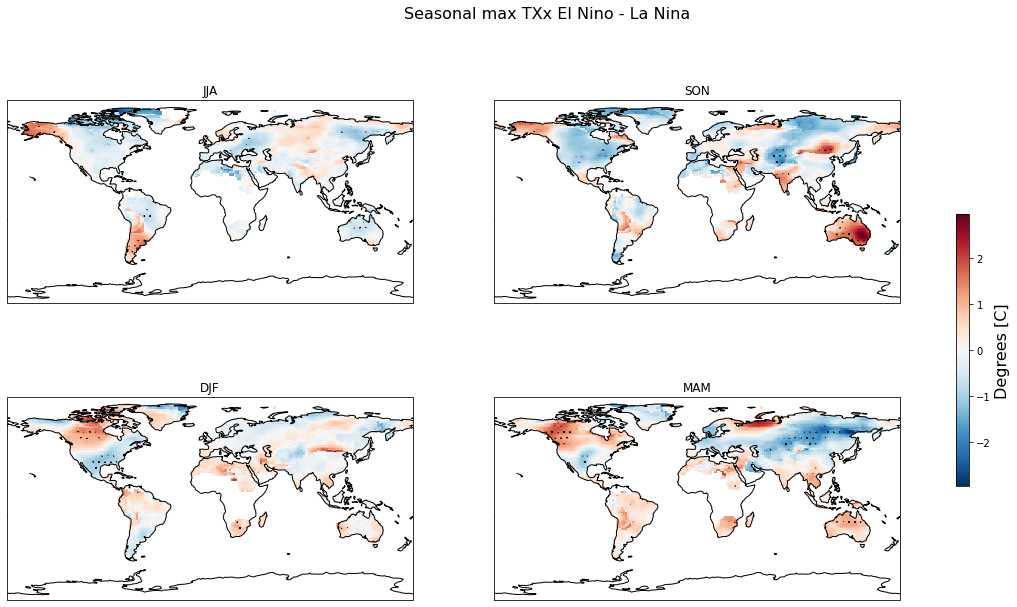

In [35]:
#plot differenec between el nino and la nina TXx for each season with stippling indicating statistical significance 
fig = plt.figure(figsize=(20,10))
axs = []

#vmin = 
#vmax = 

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
C = TXx_comp_diff_jja.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdBu_r')
plt.contourf(lons, lats, p_sig_jja, hatches=[None,'..'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.set_title('JJA')
axs.append(ax)

ax = fig.add_subplot(222, projection=ccrs.PlateCarree())
C = TXx_comp_diff_son.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdBu_r')
plt.contourf(lons, lats, p_sig_son, hatches=[None,'..'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.set_title('SON')
axs.append(ax)

ax = fig.add_subplot(223, projection=ccrs.PlateCarree())
C = TXx_comp_diff_djf.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdBu_r')
plt.contourf(lons, lats, p_sig_djf, hatches=[None,'..'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.set_title('DJF')
axs.append(ax)

ax = fig.add_subplot(224, projection=ccrs.PlateCarree())
C = TXx_comp_diff_mam.plot(ax=ax, add_colorbar=False, transform=ccrs.PlateCarree(), cmap='RdBu_r')
plt.contourf(lons, lats, p_sig_mam, hatches=[None,'..'], colors='none', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
ax.set_title('MAM')
axs.append(ax)

cbar = plt.colorbar(C, ax=axs, shrink=0.5, pad=0.05)
cbar.ax.set_ylabel('Degrees [C]', fontsize=16)

fig.suptitle('Seasonal max TXx El Nino - La Nina', fontsize=16)